# A/B Testing and Results Analysis



- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [63]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [64]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [65]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [66]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [67]:
df.query("converted==1").user_id.nunique()/df.user_id.nunique()
#df.query("converted==1").shape[0]/df.shape[0]

0.12104245244060237

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [68]:
df.query("group=='treatment' and landing_page!='new_page'").shape[0]

1965

**f.** Do any of the rows have missing values?

In [69]:
df.query("group=='treatment' and landing_page!='new_page'").isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

 In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage. Therefore we exclude such rows from our analysis 


In [70]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2=df.drop(df.query("(group=='treatment' and landing_page!='new_page') or (group=='control' and landing_page != 'old_page')").index, axis=0)
df2.shape[0]

290585

In [71]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [72]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [73]:
df2.user_id.value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [74]:
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [75]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(index=1899, axis=0, inplace=True)
df2.shape[0]
# Check again if the row with a duplicate user_id is deleted or not
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0




**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [76]:
Ppopulation=df2.query("converted==1").shape[0]/df2.shape[0]
Ppopulation

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [77]:
Pold=df2.query("group=='control' and converted==1").shape[0]/df2.query("group=='control'").shape[0]
Pold

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [78]:
Pnew=df2.query("group=='treatment' and converted ==1").shape[0]/df2.query("group=='treatment'").shape[0]
Pnew

0.11880806551510564

In [79]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = Pnew-Pold
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [80]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**The observed difference between the probabilities suggests that the new treatment group users have lower conversion rate than the control group users. Therefore, the statistics suggests that the new treatment group users convert less and therefore the new page design should not be carried out. However, We cannot draw a conclusion based on a single probability test and we will carry out more tests(AB Test and Regression Test) to see if it supports our initial results**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider you need to make the decision just based on all the data provided.  


If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**H0(Null Hyothesis):  Pnew - Pold <= 0.**

>**H1(Alternative Hypothesis):  Pnew - Pold > 0.**

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [81]:
Pnew=Ppopulation

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [82]:
Pold=Ppopulation

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [83]:
Nnew= df2.query("group=='treatment'").user_id.nunique()
Nnew

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [84]:
Nold=df2.query("group=='control'").user_id.nunique()
Nold

145274

**e. Simulate Sample for the `treatment` Group**<br> 
We simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [85]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], Nnew, p=[1-Pnew, Pnew], replace=True)
Pprimenew=new_page_converted.mean()
Pprimenew

0.1196545316908678

**f. Simulate Sample for the `control` Group** <br>
We also simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [86]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], Nold, p=[1-Pold,Pold] ,replace=True)
Pprimeold = old_page_converted.mean()
Pprimeold

0.12070983107782535

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [87]:
diff_prime = Pprimenew - Pprimeold
diff_prime

-0.001055299386957545


**h. Sampling distribution** <br>
We Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
And Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [88]:
# Sampling distribution 
#p_diffs = []

#for _ in range(10000):
#    new_page_converteds = np.random.choice([0,1], Nnew, p=[1-Pnew,Pnew], replace=True)
#    old_page_converteds = np.random.choice([0,1], Nold, p=[1-Pold,Pold], replace=True)
#    Pprimenews=new_page_converteds.mean()
#    Pprimeolds = old_page_converteds.mean()
#    p_diffs.append(Pprimenews - Pprimeolds)

In [89]:
new_page_converteds = np.random.binomial( Nnew, Pnew, 10000)/Nnew
old_page_converteds = np.random.binomial( Nold, Pold, 10000)/Nold
p_diffs = new_page_converteds - old_page_converteds
p_diffs

array([0.0005348 , 0.00111969, 0.00147053, ..., 0.00106464, 0.00156023,
       0.00130589])

**i. Histogram**<br> 
We Plot a histogram of the **p_diffs**.<br><br>
And Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart. 

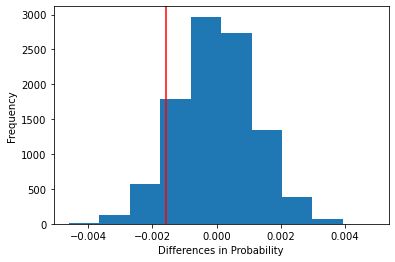

In [90]:
plt.hist(p_diffs)
plt.xlabel('Differences in Probability')
plt.ylabel('Frequency')
plt.axvline(obs_diff, c='red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [91]:
p_diffs=np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9074

**k.** what we have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?

>**This p_diff is called the p-value.**
>**Since the p-value is close to 1 and above 50%, we fail to reject the null hypothesis.**
**Therefore, the difference between the conversion rates for the new and old pages is not significant**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [92]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("converted==1 and landing_page=='old_page'").converted.sum()

# number of conversions with the new_page
convert_new = df2.query("converted==1 and landing_page=='new_page'").converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query("landing_page=='old_page'").user_id.nunique()

# number of individuals who received new_page
n_new = df2.query("landing_page=='new_page'").user_id.nunique()


### About the two-sample z-test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. We can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 


For a right-tailed test, we reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, we reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

---


In [93]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Here we fail to reject the null, This is a right_tailed test and the since the Z_score computed is less than 1.645 and it lies in the region of the null hypothesis as we did in parts k**
>**We also see that the p values computed in parts j and k are similar and approximately 0.9**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

>**A Logistic Regression is performed since there are only two outcomes: conversion or no conversion being considered.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [94]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [95]:
df2['ab_page']=pd.get_dummies(df2['group'])['treatment']
df2['intercept'] = 1;
df2.head()


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [96]:
lr = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [97]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-04-21 12:18 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [98]:
np.exp(results.params), 1/np.exp(results.params)

(intercept    0.136863
 ab_page      0.985123
 dtype: float64,
 intercept    7.306593
 ab_page      1.015102
 dtype: float64)

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



>**The p value associated with the ab_page is 0.1899 and it tells us whether the result is statistically significant or not. This p value is different from the p values computed earlier because by default, the program does a 2 tailed test which gives us just enough information as to whether the result is statistically significant or not. In this case, since the p value is greater than the type 1 error rate of 0.005, the result is statistically significant**

>**The Null Hypotheses here is that the conversion rate for the treatment group and control group is the same and
The Alternative hypothesis is that the conversion rate for the treatment group and control group is not the same. It is a Two-tailed**

>**H(o) = Pnew - Pold = 0 for Null Hypotheses and H(A) = Pnew - Pold != 0 for Alternative Hypotheses**

>**Therefore, it is a two tailed hypotheses test.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It is always a good idea to consider other factors that may affect the conversion rate. This is especially true if the relationship between the explanatory variable and dependent variable is not perfecty linear. One disadvantage is that if the independent variables are linearly correlated with each other, we stand the risk of misinterpretation of the results due to over sensitivity**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [99]:
# Read the countries.csv
df3 = pd.read_csv('countries.csv')

In [100]:
# Join with the df2 dataframe
df_merged = df2.merge(df3, on='user_id', how='inner')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [101]:
# Create the necessary dummy variables
dummy_countries = pd.get_dummies(df_merged['country'])
df_mergednew =df_merged.join(dummy_countries)

df_mergednew.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [102]:
# Fit your model, and summarize the results

df_mergednew['intercept'] = 1

lr2 = sm.Logit(df_mergednew['converted'], df_mergednew[['intercept', 'CA', 'UK']])
results2 = lr2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-04-21 12:18 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [103]:
np.exp(results2.params), 1/np.exp(results2.params)

(intercept    0.135779
 CA           0.960018
 UK           1.009966
 dtype: float64,
 intercept    7.364925
 CA           1.041647
 UK           0.990133
 dtype: float64)

In [104]:
df_mergednew2 = df_mergednew.copy()
df_mergednew2['UK_ab_page'] = df_mergednew2['UK'] * df_mergednew2['ab_page']
df_mergednew2['CA_ab_page'] = df_mergednew2['CA'] * df_mergednew2['ab_page']
df_mergednew2['intercept'] = 1
df_mergednew2.head(10)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,UK_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1,US,0,0,1,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1,US,0,0,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,0,1


In [105]:
lr3 = sm.Logit(df_mergednew2['converted'], df_mergednew2[['intercept','ab_page','CA','UK', 'CA_ab_page', 'UK_ab_page']])
results3 = lr3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-04-21 12:19 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [106]:
np.exp(results3.params), 1/np.exp(results3.params)

(intercept     0.137178
 ab_page       0.979646
 CA            0.982625
 UK            0.994272
 CA_ab_page    0.954198
 UK_ab_page    1.031896
 dtype: float64,
 intercept     7.289813
 ab_page       1.020776
 CA            1.017682
 UK            1.005761
 CA_ab_page    1.048001
 UK_ab_page    0.969090
 dtype: float64)

>**Here, we would like to know if the location of the users is affected by their location(country). The Null Hypotheses, H(O) would be that the difference in conversion rates for US, UK and CAD are the same or equal to zero. While, the Alternative Hypotheses will be that the difference in the conversion rates for US,UK and CA are different or not equal to zero**

>**The country US is used as a baseline and the p values for UK and CA suggest that they are greater than 0.05(type 1 error rate) and therefore, we fail to reject the null since they are not statistically significant.**

>**The slope params also tell us that new users in US are 1.04 times less likely to convert than users in CA keeping other variables constant and that new users in US are 1.009966 more likely to convert than users in UK keeping other variables constant**

>**Looking at the interaction between ab_page and country to see if there is any significant effect on conversion, we see that the p value for the CA_ab_page and UK_ab_page are greater than 0.005 and is not statistically significant.**


>***In Conclusion, Based on our test results including probability test, AB test, and Logistic Regression test, they all suggest that we fail to reject the Null Hypotheses; this means that the company should not implement the new page design because there is no significant effect on conversion considering a type 1 error rate of 0.05. Considering these, I recommend that we should maintain the old page and not implement the new page design yet. However, we should run the experiment for a longer duration over a larger population till we get significant results**